## Load Packages

In [1]:
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Concatenate, Conv2D, Flatten, Dense
from keras.applications.mobilenet_v2 import MobileNetV2
from one_hot_encoder import one_hot_encode_sex, one_hot_encode_localization, one_hot_encode_dx

## Constants

In [2]:
N_CLASSES_PREDICTOR = 7

# [age, sex, localization]
N_DIM_AGE = 1
N_DIM_SEX = 3
N_DIM_LOCALIZATION = 15
BATCH_SIZE = 16
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
IMAGE_CHANNELS = 3

## Create Model

In [3]:
# Define two input layers
image_input = Input((IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))

# 1. AGE INPUT
age_input = Input((N_DIM_AGE))

# 2. SEX INPUT
sex_input = Input((N_DIM_SEX))

# 3. LOCALIZATION INPUT
localization_input = Input((N_DIM_LOCALIZATION))

# 4. IMAGE INPUT: Convolution + Flatten for the image
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
base_model.trainable = False
conv_layer = base_model(image_input)
conv_input = Flatten()(conv_layer)

# Concatenate the convolutional features and the vector input
concat_layer = Concatenate()([age_input, sex_input, localization_input, conv_input])
cl_layer1 = Dense(512, activation="relu")(concat_layer)
cl_layer2 = Dense(512, activation="relu")(cl_layer1)
output = Dense(N_CLASSES_PREDICTOR, activation="softmax")(cl_layer2)

# define a model with a list of two inputs
model = Model(inputs=[age_input, sex_input, localization_input, image_input], outputs=output)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy', 'val_accuracy'])

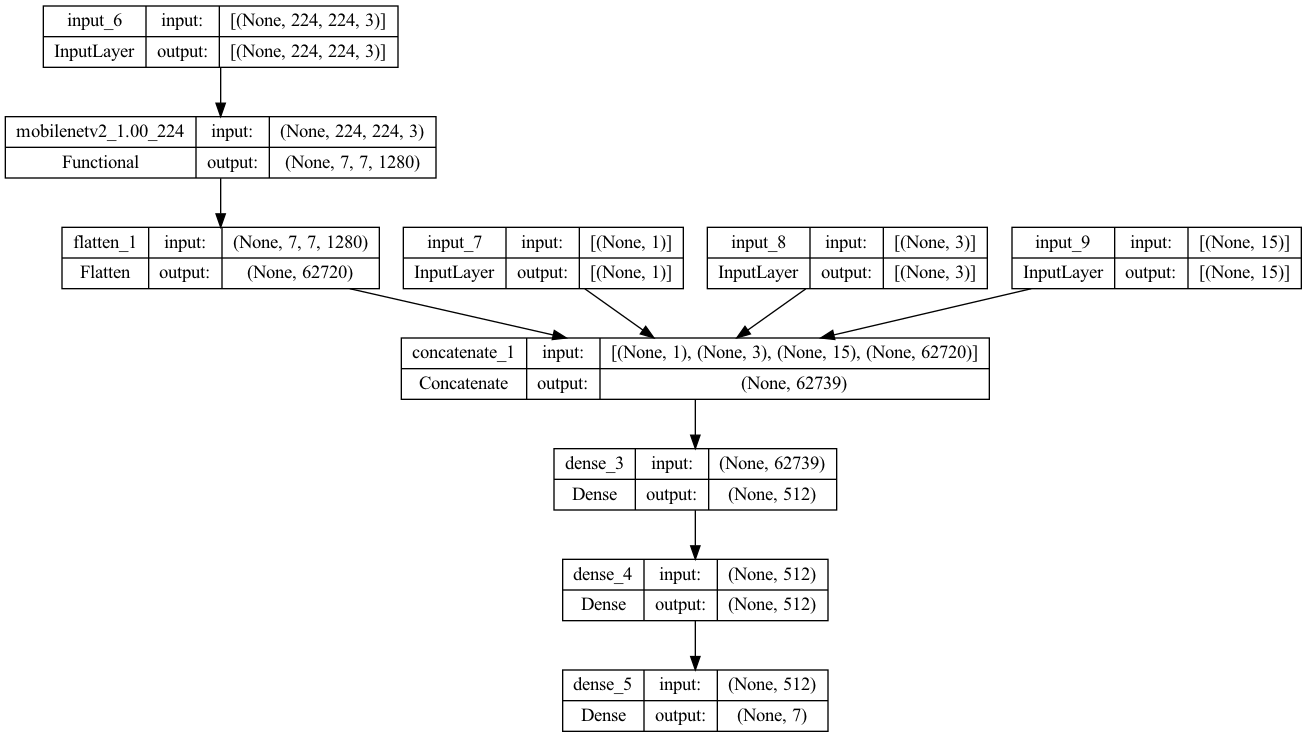

In [4]:
dot_img_file = 'model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [5]:
model.predict([np.zeros((1, N_DIM_AGE)), np.zeros((1, N_DIM_SEX)), np.zeros((1, N_DIM_LOCALIZATION)), np.zeros((1, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))])

2022-11-13 13:55:08.970319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 433ms/step


array([[0.0483103 , 0.02977933, 0.44580474, 0.06156756, 0.04049932,
        0.21462074, 0.159418  ]], dtype=float32)

## Create Data Generator

In [34]:
train_df = pd.read_csv("train.csv", delimiter=";")
validation_df = pd.read_csv("validation.csv", delimiter=";")

In [43]:
class Generator(tf.keras.utils.Sequence):

    def __init__(self, df, X_col, y_col, batch_size, input_size, shuffle=True):
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        self.data_generator_size = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __get_input(self, image_id, target_size):
        image = tf.keras.preprocessing.image.load_img("dataset/"+image_id[0]+".jpg")
        image_arr = tf.keras.preprocessing.image.img_to_array(image)
        image_arr = tf.image.resize(image_arr, [224, 224], antialias=True, method="bicubic")
        
        return [image_arr,
                self.df.loc[self.df['image_id'] == image_id[0]].age.values[0],
                one_hot_encode_sex(self.df.loc[self.df['image_id'] == image_id[0]].sex.values[0]), 
                one_hot_encode_localization(self.df.loc[self.df['image_id'] == image_id[0]].localization.values[0])]

    def __get_output(self, label, num_classes):
        return one_hot_encode_dx(label)

    def __get_data(self, batches):
        image_id_batch = batches[self.X_col]
        label_batch = batches[self.y_col]
        
        X_batch = np.asarray([self.__get_input(x, self.input_size) for x in zip(image_id_batch)])
        y0_batch = np.asarray([self.__get_output(y, N_CLASSES_PREDICTOR) for y in label_batch])

        return X_batch, y0_batch

    def __getitem__(self, index):
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)
        return X, y

    def __len__(self):
        return self.data_generator_size // self.batch_size

In [44]:
train_generator = Generator(train_df, X_col="image_id", y_col="dx", batch_size = BATCH_SIZE, input_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
validation_generator = Generator(validation_df, X_col="image_id", y_col="dx", batch_size = BATCH_SIZE, input_size=(IMAGE_HEIGHT, IMAGE_WIDTH))

In [45]:
for bt in train_generator:
    print(bt[0][0][0].shape, bt[1].shape)
    break

(16, 4)
(224, 224, 3) (16, 7)


/var/folders/qy/5gtwsk6s7jgbknbqgb533x9w0000gn/T/ipykernel_17452/2006482216.py:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_batch = np.asarray([self.__get_input(x, self.input_size) for x in zip(image_id_batch)])


In [46]:
history = model.fit(train_generator, epochs=1000, verbose=1, validation_data=validation_generator)

(16, 4)


/var/folders/qy/5gtwsk6s7jgbknbqgb533x9w0000gn/T/ipykernel_17452/2006482216.py:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_batch = np.asarray([self.__get_input(x, self.input_size) for x in zip(image_id_batch)])


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type tensorflow.python.framework.ops.EagerTensor).